In [2]:
import os
from google.colab import drive

!rm -rf /content/drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
#Labraries
!pip install kagglehub -q

import kagglehub
import os
import zipfile
from pathlib import Path
from time import time

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from google.colab import drive
PROJECT_DIR = "/content/drive/MyDrive/NN_Project"
os.makedirs(PROJECT_DIR, exist_ok=True)

MODEL_PATH = PROJECT_DIR + "/cnn_baseline_model.h5"
HISTORY_PATH = PROJECT_DIR + "/cnn_baseline_history.npy"

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [8]:
#Downloading the dataset straight from Kaggle

#Download τhe dataset
print("Downlading the dataset from Kaggle...")
path = kagglehub.dataset_download("aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented")
print("Saved at:", path)

target_dir = "/content/alzheimers_data"

#Find the zip file
zip_files = [f for f in os.listdir(path) if f.endswith(".zip")]

if zip_files:
    zip_path = os.path.join(path, zip_files[0])
    print("It's a zip file:", zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(target_dir)
    print("Extraction of the file is done at:", target_dir)
else:
    print("No zip file found, the file is already extracted.")
    target_dir = path

#Print the content of the file
print("Content of the file:", os.listdir(target_dir))


Downlading the dataset from Kaggle...


100%|██████████| 398M/398M [00:06<00:00, 67.5MB/s]

Extracting files...


Saved at: /root/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1
No zip file found, the file is already extracted.
Content of the file: ['combined_images']


In [9]:
#Loading and Preprocessing all Images from the Dataset
root_path = Path(target_dir)
if(root_path / "combined_images").exists():
    ROOT = root_path / "combined_images"
else:
    ROOT = root_path

print("Using ROOT:", ROOT)
print("Subfolders:", [p.name for p in ROOT.iterdir() if p.is_dir()])

#Image Size
IMG_SIZE = (64, 64)
COLOR_MODE = "L" #"L" is for grayscale, "RGB" for colored

#The different classes
CLASS_NAMES = sorted([p.name for p in ROOT.iterdir() if p.is_dir()])
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}
ID_TO_CLASS = {i: c for c, i in CLASS_TO_ID.items()}
print("Classes:", CLASS_NAMES)

def load_images(root, img_size=IMG_SIZE, color_mode=COLOR_MODE):
    X_flat, X_img, y = [], [], []

    if color_mode == "L":
      channels = 1
    else:
      channels = 3

    for cls in CLASS_NAMES:
      class_dir = root / cls
      for ext in ("*.jpg","*.jpeg","*.png"):
          for fp in class_dir.rglob(ext):
              #Open the image
              im = Image.open(fp).convert(color_mode).resize(img_size)
              arr = np.asarray(im, dtype=np.float32)/255.0

              X_flat.append(arr.flatten())

              #For CNN
              if channels ==1:
                arr_cnn = np.expand_dims(arr, axis=-1)
              else:
                arr_cnn = arr
              X_img.append(arr_cnn)
              y.append(CLASS_TO_ID[cls])

    X_flat = np.array(X_flat, dtype=np.float32)
    X_img = np.array(X_img, dtype=np.float32)
    y = np.array(y, dtype=int)

    return X_flat, X_img, y

print("Loading all images from combined_images...")
X_flat, X_img, y = load_images(ROOT)
print("Total number of images:", len(y))
print("X_flat shape:", X_flat.shape) #(N, 64*64)
print("X_img shape:", X_img.shape)  #(N, 64, 64, 1)


Using ROOT: /root/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1/combined_images
Subfolders: ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Loading all images from combined_images...
Total number of images: 44000
X_flat shape: (44000, 4096)
X_img shape: (44000, 64, 64, 1)


In [ ]:
#Train and Test split
X_flat_train, X_flat_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_flat, X_img, y,
    test_size=0.4,
    stratify=y,
    random_state=42
)

print("X_flat_train shape:", X_flat_train.shape, "| X_flat_test:", X_flat_test.shape)
print("X_img_train:", X_img_train.shape, "| X_img_test:", X_img_test.shape)
print("y_train size:", len(y_train), "| y_test size:", len(y_test))

X_flat_train shape: (26400, 4096) | X_flat_test: (17600, 4096)
X_img_train: (26400, 64, 64, 1) | X_img_test: (17600, 64, 64, 1)
y_train size: 26400 | y_test size: 17600


In [ ]:
#kNN and NCC for endiamesi

#kNN with k=1
time_start = time()
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_flat_train, y_train)
pred1 = knn1.predict(X_flat_test)
time1 = time() - time_start
acc1 = accuracy_score(y_test, pred1)
print(f"kNN (k=1) Accuracy: {acc1:.3f} | Time: {time1:.3f} secs")

#kNN with k=3
time_start = time()
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_flat_train, y_train)
pred2 = knn3.predict(X_flat_test)
time2 = time() - time_start
acc2 = accuracy_score(y_test, pred2)
print(f"kNN (k=3) Accuracy: {acc2:.3f} | Time: {time2:.3f} secs")

#NCC
time_start = time()
ncc = NearestCentroid()
ncc.fit(X_flat_train, y_train)
pred3 = ncc.predict(X_flat_test)
time3 = time() - time_start
acc3 = accuracy_score(y_test, pred3)
print(f"NCC Accuracy: {acc3:.3f} | Time: {time3:.3f} secs")

kNN (k=1) Accuracy: 0.818 | Time: 156.573 secs
kNN (k=3) Accuracy: 0.806 | Time: 152.433 secs
NCC Accuracy: 0.409 | Time: 3.487 secs


In [ ]:
#Cell_8
from tensorflow.keras.utils import to_categorical

num_classes = len(CLASS_NAMES)

#One-hot encoding for labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

#Split the training into training/validation
X_img_train_sub, X_img_val, y_train_sub, y_val_sub = train_test_split(
    X_img_train, y_train_cat,
    test_size=0.2,
    stratify=y_train_cat,
    random_state=42
)

print("Train subset:", X_img_train_sub.shape)
print("Validation:", X_img_val.shape)
print("Test set:", X_img_test.shape)

#A List for all the experiments
experiments = []

Train subset: (21120, 64, 64, 1)
Validation: (5280, 64, 64, 1)
Test set: (17600, 64, 64, 1)


In [ ]:
#Build the CNN Architecture
from tensorflow import keras
def build_cnn_model(input_shape, base_filters=32, dense_units=128, dropout_rate=0.5, learning_rate=1e-3, activation_type="relu"):
    """
    Builds a convolutional neural network for image classification.

    Parameters:
        input_shape (tuple): Shape of input images (H, W, C)
        base_filters (int): Number of filters in the first Conv layer
        dense_units (int): Number of units in the dense fully-connected layer
        dropout_rate (float): Dropout probability to reduce overfitting
        learning_rate (float): Learning rate
        activation_type (str): Activation type for hidden layers: 'relu' or 'leakyrelu' or 'elu' or 'sigmoid' or 'tanh'

    Returns:
        model (keras.Model): Compiled CNN model ready for training
    """

    #For leakyRelu wwe add the activation manually after each layer
    if activation_type == "leakyrelu":
      activation = None
    else:
      activation = activation_type

    model = keras.Sequential()

    #First Conv block
    model.add(keras.layers.Conv2D(base_filters, (3, 3), activation=activation, padding='same', input_shape=input_shape))
    if activation_type == "leakyrelu":
      model.add(keras.layers.LeakyReLU(alpha=0.01))

    model.add(keras.layers.MaxPooling2D((2, 2)))

    #Second Conv block
    model.add(keras.layers.Conv2D(2*base_filters, (3,3), activation=activation, padding='same'))
    if activation_type == "leakyrelu":
      model.add(keras.layers.LeakyReLU(alpha=0.01))

    model.add(keras.layers.MaxPooling2D((2, 2)))

    #Third Conv block
    model.add(keras.layers.Conv2D(4*base_filters, (3,3), activation=activation, padding='same'))
    if activation_type == "leakyrelu":
      model.add(keras.layers.LeakyReLU(alpha=0.01))

    model.add(keras.layers.MaxPooling2D((2, 2)))

    #Dense layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(dense_units, activation=activation))
    if(activation_type == "leakyrelu"):
      model.add(keras.layers.LeakyReLU(alpha=0.01))

    model.add(keras.layers.Dropout(dropout_rate))

    #Output layer
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    #Compile
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = X_img_train_sub.shape[1:]
print("Input shape:", input_shape)

Input shape: (64, 64, 1)


In [3]:

from tensorflow import keras
from tensorflow.keras.models import load_model

#Train a baseline of CNN model

#Define hyperparameters for the baseline experiment
dense_units = 128
base_filters = 32
dropout_rate = 0.5
learning_rate = 1e-3
batch_size = 32
epochs = 15

#This variable will hold the training history(either loaded or newly created)
history_dict = None

if os.path.exists(MODEL_PATH):
    #Model file already exists
    print(f"Found saved model at: {MODEL_PATH}")
    print("Loading baseline CNN model from disk (skipping training)...")

    model = load_model(MODEL_PATH)

    #Try to load previous training history if it exists
    if os.path.exists(HISTORY_PATH):
        print(f"Found saved training history at: {HISTORY_PATH}")
        history_dict = np.load(HISTORY_PATH, allow_pickle=True).item()
    else:
        print("No saved training history found. You can still evaluate the model.")

else:
    #No model file so train and save
    print("No saved model found. Training a new baseline CNN model...")

    model = build_cnn_model(
        input_shape=input_shape,
        base_filters=base_filters,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    model.summary()

    #Early stopping to avoid overfitting and unnecessary epochs
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    start_time = time()

    history = model.fit(
        X_img_train_sub, y_train_sub,
        validation_data=(X_img_val, y_val_sub),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    train_time = time() - start_time
    print(f"Training time: {train_time:.2f} seconds")

    #Convert training history object to a plain dict for saving
    history_dict = history.history

    #Save the trained model and history to disk
    model.save(MODEL_PATH)
    print(f"Baseline CNN model saved to: {MODEL_PATH}")

    np.save(HISTORY_PATH, history_dict)
    print(f"Training history saved to: {HISTORY_PATH}")

    #Training/validation accuracy (last epoch)
    train_acc = history.history['accuracy'][-1]
    val_acc   = history.history['val_accuracy'][-1]

    #Test accuracy
    test_loss, test_acc = model.evaluate(X_img_test, y_test_cat, verbose=0)
    print(f"Test accuracy: {test_acc:.3f}")

    #Log experiment results
    experiment_result = {
        "model_name": "CNN_baseline",
        "base_filters": base_filters,
        "dense_units": dense_units,
        "dropout_rate": dropout_rate,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": len(history.history['loss']),
        "activation_type": "relu",
        "train_accuracy": float(train_acc),
        "val_accuracy": float(val_acc),
        "test_accuracy": float(test_acc),
        "train_time_sec": float(train_time),
        "notes": "Baseline CNN model"
    }

    experiments.append(experiment_result)

NameError: name 'MODEL_PATH' is not defined

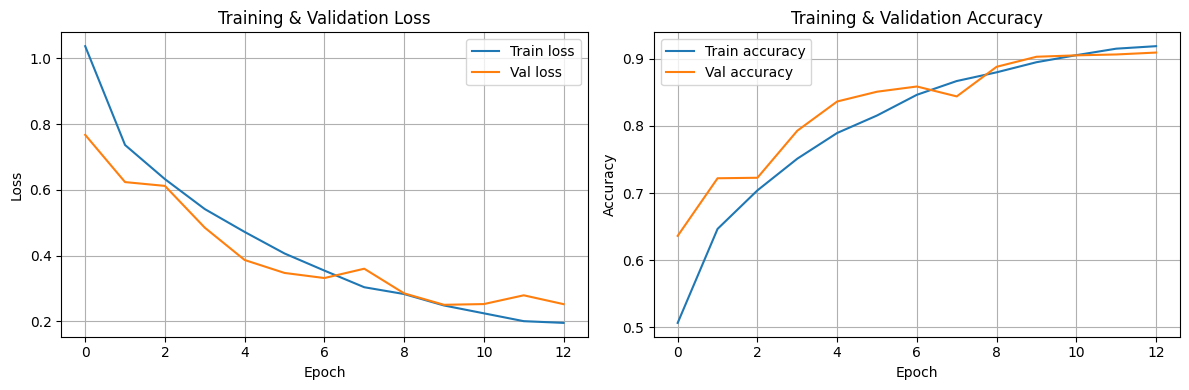

,model_name,base_filters,dense_units,dropout_rate,learning_rate,batch_size,epochs,activation_type,train_accuracy,val_accuracy,test_accuracy,train_time_sec,notes
0,CNN_baseline,32,128,0.5,0.001,32,13,relu,0.918797,0.90928,0.912216,2586.618709,Baseline CNN model


In [ ]:
#Plot training and validation curves

if 'history_dict' in globals() and history_dict is not None:
    #history_dict came either from new training or from loaded .npy file
    train_loss = history_dict.get('loss', [])
    val_loss   = history_dict.get('val_loss', [])
    train_acc  = history_dict.get('accuracy', [])
    val_acc    = history_dict.get('val_accuracy', [])

    if len(train_loss) > 0:
        plt.figure(figsize=(12,4))

        #Loss curve
        plt.subplot(1,2,1)
        plt.plot(train_loss, label='Train loss')
        if len(val_loss) > 0:
            plt.plot(val_loss, label='Val loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Loss')
        plt.legend()
        plt.grid(True)

        #Accuracy curve
        plt.subplot(1,2,2)
        plt.plot(train_acc, label='Train accuracy')
        if len(val_acc) > 0:
            plt.plot(val_acc, label='Val accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training & Validation Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("History dictionary is empty. No curves to plot.")
else:
    print("No training history found (history_dict is not defined).")

#Show current experiments table if any
if len(experiments) > 0:
    display(pd.DataFrame(experiments))
else:
    print("No experiments logged yet.")


Using hidden layer for features: dense_2
Extracted features shape: (2000, 128)


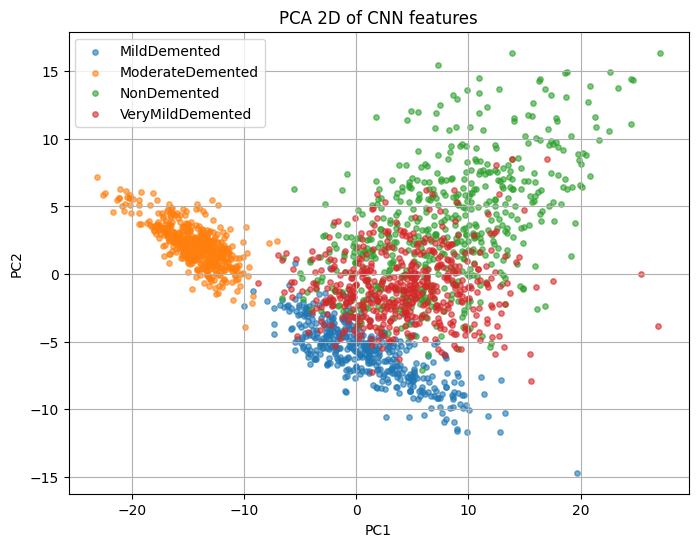

In [ ]:
#PCA on CNN feature space

#Find the last hidden dense layer
last_hidden_dense = None
for layer in reversed(model.layers):
  if isinstance(layer, keras.layers.Dense) and layer.units != num_classes:
    last_hidden_dense = layer
    break

if last_hidden_dense is None:
  print("No hidden dense layer found in the model.")
else:
  print("Using hidden layer for features:", last_hidden_dense.name)

  if not model.built:
    _ = model(tf.zeros((1,) + input_shape)) #dummy forward pass

  input_tensor_for_extractor = model.layers[0].input

  #Build feature extractor model from input to this hidden Dense layer
  feature_extractor = keras.Model(inputs=input_tensor_for_extractor, outputs=last_hidden_dense.output)

  #Use a subset of the test set for PCA visualization
  max_samples_for_pca = 2000
  n_samples = min(max_samples_for_pca, len(X_img_test))
  idx = np.random.choice(len(X_img_test), size=n_samples, replace=False)

  X_img_sample = X_img_test[idx]
  y_sample = y_test[idx]

  #Extract features from CNN
  features = feature_extractor.predict(X_img_sample, verbose=0)
  print("Extracted features shape:", features.shape)

  #PCA to 2D
  pca_cnn = PCA(n_components=2, random_state=42)
  features_2D = pca_cnn.fit_transform(features)

  #Plot
  plt.figure(figsize=(8, 6))
  for class_id, class_name in ID_TO_CLASS.items():
    mask = (y_sample == class_id)
    plt.scatter(features_2D[mask,0], features_2D[mask,1], label=class_name, alpha=0.6, s=15)

  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.title("PCA 2D of CNN features")
  plt.legend()
  plt.grid(True)
  plt.show()

Classification report (baseline CNN):
                  precision    recall  f1-score   support

    MildDemented       0.90      0.92      0.91      4000
ModerateDemented       0.99      1.00      0.99      4000
     NonDemented       0.89      0.91      0.90      5120
VeryMildDemented       0.88      0.83      0.85      4480

        accuracy                           0.91     17600
       macro avg       0.91      0.91      0.91     17600
    weighted avg       0.91      0.91      0.91     17600



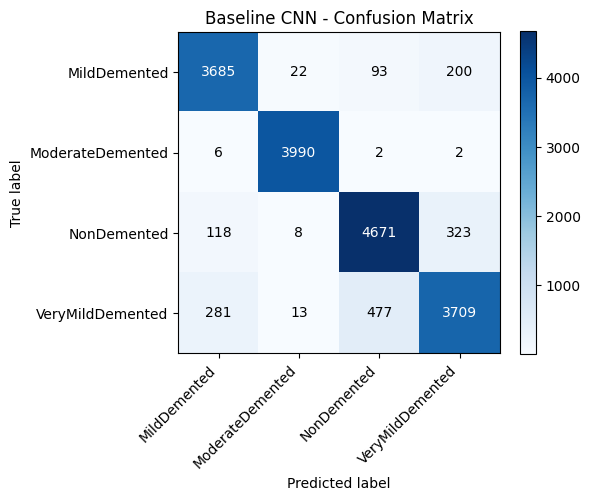

Correct predictions: 16055
Wrong predictions:   1545


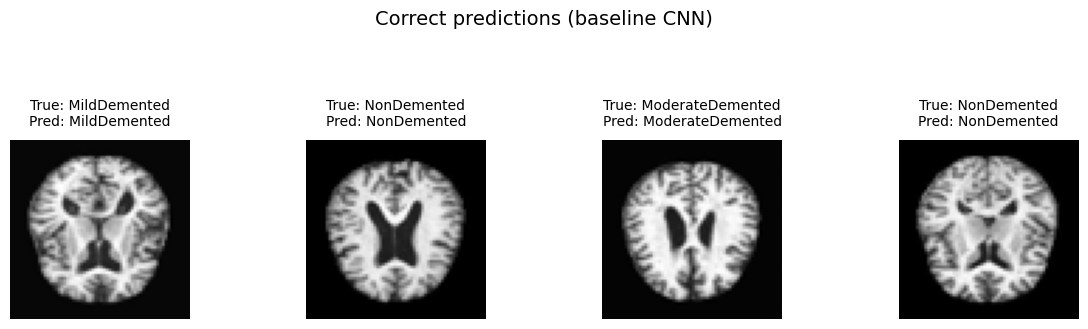

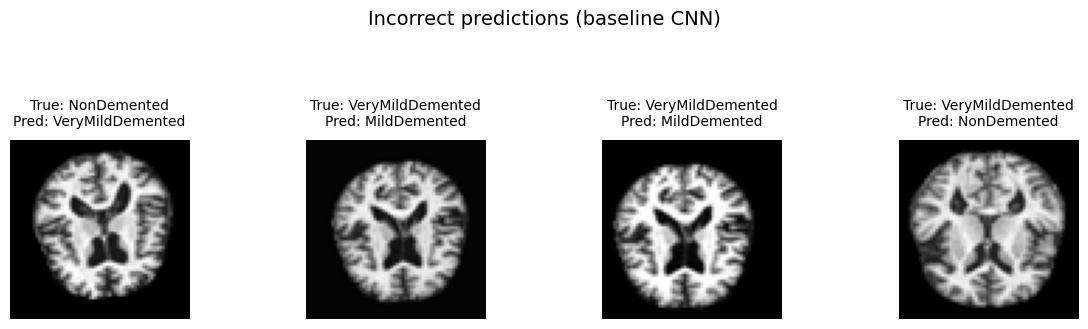

In [ ]:
#Evaluasion of baseline CNN  test set and some correct/wrong examples

#Prediction of tje baseline CNN
y_test_proba = model.predict(X_img_test, verbose=0)
y_test_pred = np.argmax(y_test_proba, axis=1)

# Classification report
print("Classification report (baseline CNN):")
print(classification_report(y_test, y_test_pred, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Baseline CNN - Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES)

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

#Correct/wrong examples of the baseline CNN
correct_idx = np.where(y_test_pred == y_test)[0]
wrong_idx   = np.where(y_test_pred != y_test)[0]

print(f"Correct predictions: {len(correct_idx)}")
print(f"Wrong predictions:   {len(wrong_idx)}")

n_show = 4

def show_examples(indices, title):
    n = min(len(indices), n_show)
    if n == 0:
        print(f"No examples to show for: {title}")
        return

    plt.figure(figsize=(12, 3))
    plt.suptitle(title, fontsize=14, y=1.08)

    for i in range(n):
        idx = indices[i]
        img = X_img_test[idx].squeeze()
        true_label = ID_TO_CLASS[y_test[idx]]
        pred_label = ID_TO_CLASS[y_test_pred[idx]]

        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, pad=10)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

show_examples(correct_idx, "Correct predictions (baseline CNN)")
show_examples(wrong_idx,   "Incorrect predictions (baseline CNN)")

In [ ]:
#Extra CNN experiments with different hyperparameters

from tensorflow import keras

#Deifferent CNN configs
cnn_configs = [
    {
        "name": "cnn_full_base32_dense128",
        "base_filters": 32,
        "dense_units": 128,
        "dropout_rate": 0.5,
        "learning_rate": 1e-3,
        "batch_size": 32,
        "epochs": 15,
        "train_fraction": 1.0
    },
    {
        "name": "cnn_more_filters64_dense128",
        "base_filters": 64,
        "dense_units": 128,
        "dropout_rate": 0.5,
        "learning_rate": 1e-3,
        "batch_size": 32,
        "epochs": 15,
        "train_fraction": 1.0
    },
    {
        "name": "cnn_base32_dense256",
        "base_filters": 32,
        "dense_units": 256,
        "dropout_rate": 0.5,
        "learning_rate": 1e-3,
        "batch_size": 32,
        "epochs": 15,
        "train_fraction": 1.0
    },
    {
        "name": "cnn_half_data_base32_dense128",
        "base_filters": 32,
        "dense_units": 128,
        "dropout_rate": 0.5,
        "learning_rate": 1e-3,
        "batch_size": 32,
        "epochs": 15,
        "train_fraction": 0.5
    },
    {
        "name": "cnn_dropoutRate_learningRate_batchSize",
        "base_filters": 32,
        "dense_units": 128,
        "dropout_rate": 0.7,
        "learning_rate": 5e-4,
        "batch_size": 64,
        "epochs": 15,
        "train_fraction": 1.0
    },
]

extra_experiments = []

for cfg in cnn_configs:
    print("=" * 60)
    print(f"Training extra CNN: {cfg['name']}")
    print(cfg)

    if cfg["train_fraction"] < 1.0:
        n_samples = int(cfg["train_fraction"] * len(X_img_train_sub))
        idx = np.random.choice(len(X_img_train_sub), size=n_samples, replace=False)
        X_train_exp = X_img_train_sub[idx]
        y_train_exp = y_train_sub[idx]
        print(f"Using only {n_samples} samples out of {len(X_img_train_sub)} for training.")
    else:
        X_train_exp = X_img_train_sub
        y_train_exp = y_train_sub
        print(f"Using all samples for training: {X_train_exp.shape[0]} samples.")


    model_cfg = build_cnn_model(
        input_shape=input_shape,
        base_filters=cfg["base_filters"],
        dense_units=cfg["dense_units"],
        dropout_rate=cfg["dropout_rate"],
        learning_rate=cfg["learning_rate"],
        activation_type="relu"
    )

    # Early stopping
    early_stop_cfg = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    start_time = time()

    history_cfg = model_cfg.fit(
        X_train_exp, y_train_exp,
        validation_data=(X_img_val, y_val_sub),
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        callbacks=[early_stop_cfg],
        verbose=1
    )

    train_time = time() - start_time
    print(f"Training time for {cfg['name']}: {train_time:.2f} seconds")

    #Final train/validation accuracy
    train_acc = history_cfg.history["accuracy"][-1]
    val_acc   = history_cfg.history["val_accuracy"][-1]

    #Test accuracy
    test_loss, test_acc = model_cfg.evaluate(X_img_test, y_test_cat, verbose=0)
    print(f"Test accuracy for {cfg['name']}: {test_acc:.3f}")

    #Save the model to Drive
    model_path = os.path.join(PROJECT_DIR, f"{cfg['name']}.h5")
    model_cfg.save(model_path)
    print(f"Saved model to: {model_path}")

    #Log the results
    exp_result = {
        "model_name": cfg["name"],
        "base_filters": cfg["base_filters"],
        "dense_units": cfg["dense_units"],
        "dropout_rate": cfg["dropout_rate"],
        "learning_rate": cfg["learning_rate"],
        "batch_size": cfg["batch_size"],
        "epochs": len(history_cfg.history["loss"]),
        "activation_type": "relu",
        "train_fraction": cfg["train_fraction"],
        "train_accuracy": float(train_acc),
        "val_accuracy": float(val_acc),
        "test_accuracy": float(test_acc),
        "train_time_sec": float(train_time),
        "notes": "Extra CNN config"
    }

    experiments.append(exp_result)
    extra_experiments.append(exp_result)

print("=" * 60)
print("All extra CNN experiments trained.")

experiments_df = pd.DataFrame(experiments)
display(experiments_df)

#Save the log to a .csv file
csv_path = os.path.join(PROJECT_DIR, "cnn_experiments_log.csv")
experiments_df.to_csv(csv_path, index=False)
print(f"Saved experiments log to: {csv_path}")


Training extra CNN: cnn_full_base32_dense128
{'name': 'cnn_full_base32_dense128', 'base_filters': 32, 'dense_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'train_fraction': 1.0}
Using all samples for training: 21120 samples.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 240s 346ms/step - accuracy: 0.4099 - loss: 1.2106 - val_accuracy: 0.6532 - val_loss: 0.7349
Epoch 2/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 211s 320ms/step - accuracy: 0.6249 - loss: 0.7856 - val_accuracy: 0.6814 - val_loss: 0.6628
Epoch 3/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 262s 320ms/step - accuracy: 0.6781 - loss: 0.6860 - val_accuracy: 0.7508 - val_loss: 0.5589
Epoch 4/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 212s 322ms/step - accuracy: 0.7198 - loss: 0.6006 - val_accuracy: 0.7900 - val_loss: 0.4895
Epoch 5/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 215s 326ms/step - accuracy: 0.7576 - loss: 0.5235 - val_accuracy: 0.8191 - val_loss: 0.4195
Epoch 6/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 215s 326ms/step - accuracy: 0.7848 - loss: 0.4791 - val_accuracy: 0.8265 - val_loss: 0.3918
Epoch 7/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 219s 333ms/step - accuracy: 0.8088 - loss: 0.4235 - val_accuracy: 0.8453 - val_loss: 0.3598
Epoch 8/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 214s 325ms/step - accuracy: 0.8269 -

Test accuracy for cnn_full_base32_dense128: 0.904
Saved model to: /content/drive/MyDrive/NN_Project/cnn_full_base32_dense128.h5
Training extra CNN: cnn_more_filters64_dense128
{'name': 'cnn_more_filters64_dense128', 'base_filters': 64, 'dense_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'train_fraction': 1.0}
Using all samples for training: 21120 samples.
Epoch 1/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 610s 919ms/step - accuracy: 0.4053 - loss: 1.2222 - val_accuracy: 0.6523 - val_loss: 0.7217
Epoch 2/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 647s 958ms/step - accuracy: 0.6203 - loss: 0.7759 - val_accuracy: 0.6994 - val_loss: 0.6446
Epoch 3/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 600s 909ms/step - accuracy: 0.6817 - loss: 0.6635 - val_accuracy: 0.7515 - val_loss: 0.5320
Epoch 4/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 627s 917ms/step - accuracy: 0.7361 - loss: 0.5634 - val_accuracy: 0.7973 - val_loss: 0.4707
Epoch 5/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 620s 914ms/step - accuracy: 0

Test accuracy for cnn_more_filters64_dense128: 0.925
Saved model to: /content/drive/MyDrive/NN_Project/cnn_more_filters64_dense128.h5
Training extra CNN: cnn_base32_dense256
{'name': 'cnn_base32_dense256', 'base_filters': 32, 'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'train_fraction': 1.0}
Using all samples for training: 21120 samples.
Epoch 1/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 224s 337ms/step - accuracy: 0.4411 - loss: 1.1607 - val_accuracy: 0.6682 - val_loss: 0.7309
Epoch 2/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 264s 339ms/step - accuracy: 0.6710 - loss: 0.6994 - val_accuracy: 0.7619 - val_loss: 0.5462
Epoch 3/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 261s 337ms/step - accuracy: 0.7444 - loss: 0.5659 - val_accuracy: 0.7941 - val_loss: 0.4644
Epoch 4/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 260s 334ms/step - accuracy: 0.7980 - loss: 0.4535 - val_accuracy: 0.8366 - val_loss: 0.3839
Epoch 5/15
660/660 ━━━━━━━━━━━━━━━━━━━━ 260s 331ms/step - accuracy: 0.8512 - lo

Test accuracy for cnn_base32_dense256: 0.918
Saved model to: /content/drive/MyDrive/NN_Project/cnn_base32_dense256.h5
Training extra CNN: cnn_half_data_base32_dense128
{'name': 'cnn_half_data_base32_dense128', 'base_filters': 32, 'dense_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'train_fraction': 0.5}
Using only 10560 samples out of 21120 for training.
Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 120s 359ms/step - accuracy: 0.3269 - loss: 1.3155 - val_accuracy: 0.5540 - val_loss: 0.9872
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 108s 328ms/step - accuracy: 0.5321 - loss: 0.9738 - val_accuracy: 0.6191 - val_loss: 0.7829
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 150s 352ms/step - accuracy: 0.6101 - loss: 0.7981 - val_accuracy: 0.6725 - val_loss: 0.6978
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 114s 347ms/step - accuracy: 0.6433 - loss: 0.7233 - val_accuracy: 0.6898 - val_loss: 0.6615
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 107s 323ms/step - accuracy: 0.

Test accuracy for cnn_half_data_base32_dense128: 0.801
Saved model to: /content/drive/MyDrive/NN_Project/cnn_half_data_base32_dense128.h5
Training extra CNN: cnn_dropoutRate_learningRate_batchSize
{'name': 'cnn_dropoutRate_learningRate_batchSize', 'base_filters': 32, 'dense_units': 128, 'dropout_rate': 0.7, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 15, 'train_fraction': 1.0}
Using all samples for training: 21120 samples.
Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 215s 645ms/step - accuracy: 0.3526 - loss: 1.3039 - val_accuracy: 0.5833 - val_loss: 0.9643
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 209s 635ms/step - accuracy: 0.5478 - loss: 0.9570 - val_accuracy: 0.6398 - val_loss: 0.7634
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 217s 657ms/step - accuracy: 0.5983 - loss: 0.8276 - val_accuracy: 0.6553 - val_loss: 0.7096
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 258s 644ms/step - accuracy: 0.6251 - loss: 0.7681 - val_accuracy: 0.6960 - val_loss: 0.6554
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━

Test accuracy for cnn_dropoutRate_learningRate_batchSize: 0.854
Saved model to: /content/drive/MyDrive/NN_Project/cnn_dropoutRate_learningRate_batchSize.h5
All extra CNN experiments trained.


,model_name,base_filters,dense_units,dropout_rate,learning_rate,batch_size,epochs,activation_type,train_fraction,train_accuracy,val_accuracy,test_accuracy,train_time_sec,notes
0,cnn_full_base32_dense128,32,128,0.5,0.0010,32,15,relu,1.0,0.915767,0.906250,0.903750,3482.696617,Extra CNN config
1,cnn_more_filters64_dense128,64,128,0.5,0.0010,32,15,relu,1.0,0.939536,0.916098,0.925227,9213.472038,Extra CNN config
2,cnn_base32_dense256,32,256,0.5,0.0010,32,13,relu,1.0,0.960038,0.922348,0.918409,3217.018459,Extra CNN config
3,cnn_half_data_base32_dense128,32,128,0.5,0.0010,32,13,relu,0.5,0.809754,0.814394,0.801364,1712.049177,Extra CNN config
4,cnn_dropoutRate_learningRate_batchSize,32,128,0.7,0.0005,64,15,relu,1.0,0.805114,0.848295,0.853864,3372.515074,Extra CNN config


Saved experiments log to: /content/drive/MyDrive/NN_Project/cnn_experiments_log.csv


In [10]:
#Load experiment results
import os
import pandas as pd

csv_path = os.path.join(PROJECT_DIR, "cnn_experiments_log.csv")

if os.path.exists(csv_path):
    print(f"Loading experiment results from: {csv_path}")
    experiments_df = pd.read_csv(csv_path)
    display(experiments_df)
else:
    print(f"No experiment results found at: {csv_path}")

Loading experiment results from: /content/drive/MyDrive/NN_Project/cnn_experiments_log.csv


,model_name,base_filters,dense_units,dropout_rate,learning_rate,batch_size,epochs,activation_type,train_fraction,train_accuracy,val_accuracy,test_accuracy,train_time_sec,notes
0,cnn_full_base32_dense128,32,128,0.5,0.0010,32,15,relu,1.0,0.915767,0.906250,0.903750,3482.696617,Extra CNN config
1,cnn_more_filters64_dense128,64,128,0.5,0.0010,32,15,relu,1.0,0.939536,0.916098,0.925227,9213.472038,Extra CNN config
2,cnn_base32_dense256,32,256,0.5,0.0010,32,13,relu,1.0,0.960038,0.922348,0.918409,3217.018459,Extra CNN config
3,cnn_half_data_base32_dense128,32,128,0.5,0.0010,32,13,relu,0.5,0.809754,0.814394,0.801364,1712.049177,Extra CNN config
4,cnn_dropoutRate_learningRate_batchSize,32,128,0.7,0.0005,64,15,relu,1.0,0.805114,0.848295,0.853864,3372.515074,Extra CNN config


In [ ]:
#Load a picture and print the prediction of each model
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#Name of the MRI image you chose
IMAGE_FILENAME = "modDemented.png"

#Path of the image
IMAGE_PATH = os.path.join("/content", IMAGE_FILENAME)

#List of all the models
model_files = [
    ("cnn_baseline_model.h5",              "CNN_baseline"),
    ("cnn_full_base32_dense128.h5",        "cnn_full_base32_dense128"),
    ("cnn_more_filters64_dense128.h5",     "cnn_more_filters64_dense128"),
    ("cnn_base32_dense256.h5",             "cnn_base32_dense256"),
    ("cnn_half_data_base32_dense128.h5",   "cnn_half_data_base32_dense128"),
    ("cnn_dropoutRate_learningRate_batchSize.h5", "cnn_dropoutRate_learningRate_batchSize"),
]

#Load image and preprocess
if not os.path.exists(IMAGE_PATH):
    print(f"Image file not found: {IMAGE_PATH}")
else:
    print(f"Loading image from: {IMAGE_PATH}")

    img = Image.open(IMAGE_PATH).convert(COLOR_MODE).resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)/255.0

    if COLOR_MODE == "L":
        img_cnn = np.expand_dims(img_array, axis=-1)
    else:
        img_cnn = image_array

    img_cnn = np.expand_dims(img_cnn, axis=0)

    #Show the image
    plt.figure(figsize=(3,3))
    if COLOR_MODE == "L":
      plt.imshow(img_array, cmap='gray')
    else:
      plt.imshow(img_array)
    plt.axis('off')
    plt.title("Input image")
    plt.show()
    print("\nPredictions for each model:\n")

    for model_file, model_name in model_files:
        model_path = os.path.join(PROJECT_DIR, model_file)

        if not os.path.exists(model_path):
            print(f"Model '{model_name}' not found at: {model_path}")
            continue

        print(f"Model loaded: {model_name} ({model_path})")
        model_loaded = load_model(model_path)

        #Prediction
        proba = model_loaded.predict(img_cnn, verbose=0)
        pred_class_id = int(np.argmax(proba, axis=1)[0])
        pred_class_name = ID_TO_CLASS[pred_class_id]
        pred_proba = proba[0][pred_class_id]

        print(f"Predicted class: {pred_class_name}:")
        print("-" * 50)

Image file not found: /content/modDemented.png
